In [69]:
!pip install gdown
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [70]:
# @title Download MoNuSeg Training Data and Convert Masks
import gdown
import os
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
from skimage.draw import polygon

def parse_xml_to_mask(xml_path, image_size):

  width, height = image_size
  mask = np.zeros((height, width), dtype=np.uint8)

  tree = ET.parse(xml_path)
  root = tree.getroot()

  for region in root.findall('.//Region'):
    for vertices in region.findall('.//Vertices'):
      row_cords = []
      col_cords = []
      for vertex in vertices.findall('.//Vertex'):
        x = float(vertex.get('X'))
        y = float(vertex.get('Y'))

        row_cords.append(y)
        col_cords.append(x)

      rr, cc = polygon(row_cords, col_cords, (height, width))
      mask[rr, cc] = 1

  return mask

if not os.path.exists('MoNuSeg'):
  # -c to skip if already downloaded. MoNuSeg is hosted on google drive
  gdown.download(id = "1ZgqFJomqQGNnsx7w7QBzQQMVA16lbVCA", output = "MoNuSeg.zip")
  !unzip MoNuSeg.zip -d MoNuSeg
  !rm MoNuSeg.zip

  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations')
  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images')

  # Convert masks to 1,000 by 1,000 px pngs
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Annotations'):
    if file.endswith('.xml'):
      xml_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Annotations', file)
      mask = parse_xml_to_mask(xml_path, (1000, 1000))
      mask = Image.fromarray(mask)
      mask.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations', file[:-4] + '.png'))
  # Convert compressed tiff to png for faster loading
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images'):
    if file.endswith('.tif'):
      img_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images', file)
      img = Image.open(img_path)
      img.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images', file[:-4] + '.png'))

else:
  print("MoNuSeg Training Data already downloaded")

MoNuSeg Training Data already downloaded


In [146]:
# @title MoNuSeg Data Set
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2
from torchvision import tv_tensors


class MoNuSegDataset(Dataset):
  def __init__(self, root_dir, transform = None, bright_contrast = False):
    """
    Args:
        root_dir (string): Directory with all the images and masks.
        transform (callable, optional): Optional transform to be applied
            on a sample. Default is random 256x256 crop.
    """
    self.root_dir = root_dir
    self.image_dir = os.path.join(root_dir, 'Proccessed Images')
    self.mask_dir = os.path.join(root_dir, 'Proccessed Annotations')

    # transform both img and mask for data augmentation
    if transform is None:
      transform = v2.RandomCrop((256,256))
    
    self.transform = transform

    # setting up data type
    self.img_transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

    if bright_contrast:
        self.img_transform = v2.Compose([v2.ToImage(), v2.RandomPhotometricDistort(brightness=0.2, contrast=0.2), v2.ToDtype(torch.float32, scale=True)])

    # Sort to ensure images and masks match
    self.images = sorted(os.listdir(self.image_dir))
    self.masks = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.image_dir, self.images[idx]))
    mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))

    # manual transform each for image and mask separately
    img = self.img_transform(img)
    mask = tv_tensors.Mask(mask)
    
    img, mask = self.transform(img, mask)

    mask = mask.squeeze(0) # Remove the channel dimension. It's a channel size of 1 anyway

    return {"image": img, "mask": mask}

In [80]:
# @title Create Dataloader
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data')

# Pin memory to speed up loading to GPU. Increase # workers
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

Number of train samples: 37


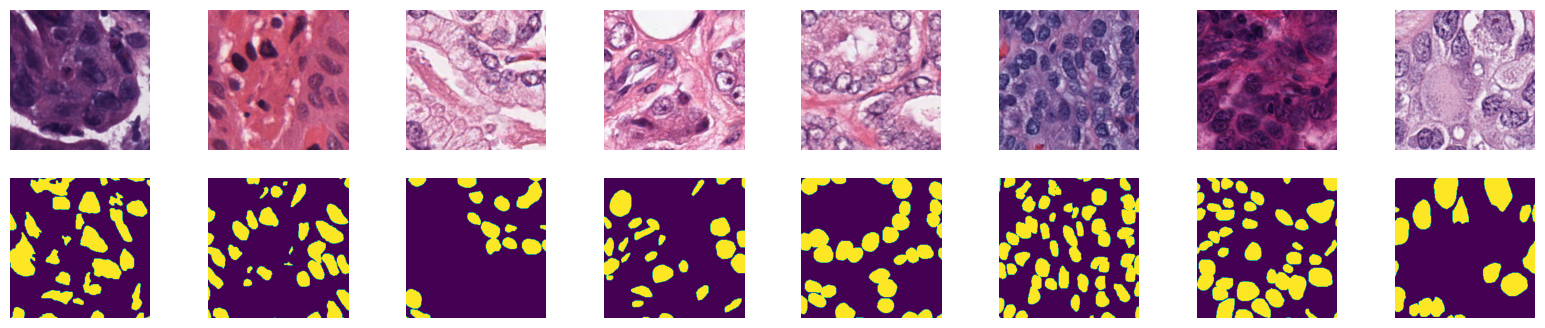

In [81]:
# @title Visualize Batch

images = next(iter(dataloader))

print(f"Number of train samples: {len(dataset)}")

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(images["mask"][i])
  axes[1,i].axis('off')

plt.show()

In [82]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [83]:
# @title Define the UNet

import torch
import torch.nn as nn

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        pooled_x = self.pool(x)

        return pooled_x, x # need to return both pooled and pre-pooled for skip connections

class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansiveBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')

    def forward(self, pooled_x, pre_x):
        pooled_x = self.up_conv(pooled_x)

        diff_Y = pre_x.size()[2] - pooled_x.size()[2]
        diff_X = pre_x.size()[3] - pooled_x.size()[3]
        x_cropped = pre_x[:, :, diff_Y // 2 : pre_x.size()[2] - diff_Y // 2,
                                    diff_X // 2 : pre_x.size()[3] - diff_X // 2]

        x = torch.cat([pooled_x, x_cropped], dim=1) # add across the channel dimensions to double the channel count

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x
        

class UNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(UNet, self).__init__()

        # Contracting Path
        self.contract1 = ContractingBlock(3, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)

        # Bottleneck Layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding='same'),
            nn.ReLU()             
        )
        
        # Expansive Path
        self.expand1 = ExpansiveBlock(1024, 512)
        self.expand2 = ExpansiveBlock(512, 256)
        self.expand3 = ExpansiveBlock(256, 128)
        self.expand4 = ExpansiveBlock(128, 64)

        # Final layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding='same')

    def forward(self, x):
        x, x_skip1 = self.contract1(x)
        x, x_skip2 = self.contract2(x)
        x, x_skip3 = self.contract3(x)
        x, x_skip4 = self.contract4(x)

        x = self.bottleneck(x)

        x = self.expand1(x, x_skip4)
        x = self.expand2(x, x_skip3)
        x = self.expand3(x, x_skip2)
        x = self.expand4(x, x_skip1)

        x = self.final_conv(x)
        
        return x


In [122]:
# @title Initialize Model (Untrained Model)

untrained_model = UNet()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [123]:
# @title Run on Samples

output = untrained_model(images['image'])

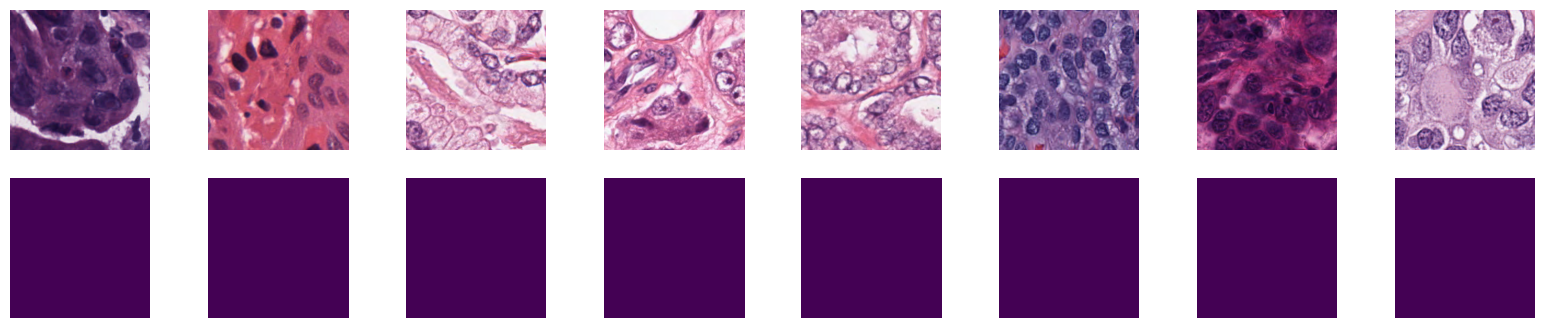

In [124]:
# @title Visualize First Batch Output (No training)
out_mask = (torch.softmax(output, dim = 1)[:,1,:,:].detach() > .5).float()

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(out_mask[i])
  axes[1,i].axis('off')

plt.show()

In [125]:
# @title Define Accuracy Function

def pixel_accuracy(pred, target):
    pred_classes = torch.argmax(pred, dim=1)  # pred = raw output from the model. convert [B, C=2, H, W] to [B, H, W] and collapsing dim=1, basically generating the mask.
    
    correct = (pred_classes == target).float()  # target = ground truth. correct = [B, H, W], 1.0 if correct else 0.0
    
    accuracy = correct.sum() / correct.numel()  # total correct / total pixels = pixel accuracry
    
    return accuracy.item() # extract the float without other info associated with the tensor

In [126]:
# @title Define Training Loop

def train(epochs, model, loss_fn, optimizer, train_loader, val_loader, lr_scheduler = None):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"): # add progress bar
            img = batch['image'].to(device=device, dtype=torch.float32)
            mask = batch['mask'].to(device=device, dtype=torch.int64)
    
            predicted_mask = model(img)
    
            loss = loss_fn(predicted_mask, mask)
    
            optimizer.zero_grad()
    
            loss.backward()
    
            optimizer.step()
    
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")
    
        # Validation
        model.eval()
        val_loss = 0.0
        acc_total = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                img = batch['image'].to(device=device, dtype=torch.float32)
                mask = batch['mask'].to(device=device, dtype=torch.int64)
    
                predicted_mask = model(img)
                
                loss = loss_fn(predicted_mask, mask)
                
                val_loss += loss.item()
    
                acc_total += pixel_accuracy(predicted_mask, mask)
    
        avg_val_loss = val_loss / len(val_loader)
        avg_acc = acc_total / len(val_loader)

        if lr_scheduler:
            lr_scheduler.step(avg_val_loss)
            
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']:.6f}")
                
        print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_acc:.4f}")

In [127]:
# @title Define Visualization 

def show_pic(model, images):
    model.eval()

    output_trained = model(images['image'].to(device=device))
    
    out_mask_trained = (torch.softmax(output_trained, dim = 1)[:,1,:,:].cpu() > .5).float()
    
    fig, axes = plt.subplots(3, 8, figsize=(20, 4))
    for i in range(8):
      axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
      axes[0,i].axis('off')
      axes[1,i].imshow(out_mask_trained[i])
      axes[1,i].axis('off')
      axes[2,i].imshow(images["mask"][i])
      axes[2,i].axis('off')
    
    plt.show()

In [128]:
# @title Create a New Instance of Model to train
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from tqdm import tqdm

model = UNet()

# do random split to set aside validation set
train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device=device)

train(epochs, model, F.cross_entropy, optimizer, train_loader, val_loader)

        

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 1, Training Loss: 0.6340


Epoch 1, Validation Loss: 0.9979, Accuracy: 0.6738


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 2, Training Loss: 0.5598


Epoch 2, Validation Loss: 0.5772, Accuracy: 0.6557


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 3, Training Loss: 0.5056


Epoch 3, Validation Loss: 0.5485, Accuracy: 0.6485


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 4, Training Loss: 0.4927


Epoch 4, Validation Loss: 0.4609, Accuracy: 0.6973


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 5, Training Loss: 0.4451


Epoch 5, Validation Loss: 0.4356, Accuracy: 0.6999


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 6, Training Loss: 0.4348


Epoch 6, Validation Loss: 0.4055, Accuracy: 0.7155


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 7, Training Loss: 0.4253


Epoch 7, Validation Loss: 0.4324, Accuracy: 0.8339


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 8, Training Loss: 0.4308


Epoch 8, Validation Loss: 0.3793, Accuracy: 0.8368


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 9, Training Loss: 0.4038


Epoch 9, Validation Loss: 0.3728, Accuracy: 0.8327


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 10, Training Loss: 0.3972


Epoch 10, Validation Loss: 0.3749, Accuracy: 0.8268


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 11, Training Loss: 0.4005


Epoch 11, Validation Loss: 0.3466, Accuracy: 0.8481


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 12, Training Loss: 0.3722


Epoch 12, Validation Loss: 0.3370, Accuracy: 0.8468


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 13, Training Loss: 0.3978


Epoch 13, Validation Loss: 0.3615, Accuracy: 0.8318


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 14, Training Loss: 0.3632


Epoch 14, Validation Loss: 0.3449, Accuracy: 0.8458


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 15, Training Loss: 0.3881


Epoch 15, Validation Loss: 0.3279, Accuracy: 0.8523


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 16, Training Loss: 0.3730


Epoch 16, Validation Loss: 0.3647, Accuracy: 0.8296


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 17, Training Loss: 0.3711


Epoch 17, Validation Loss: 0.3029, Accuracy: 0.8616


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

Epoch 18, Training Loss: 0.3889


Epoch 18, Validation Loss: 0.3193, Accuracy: 0.8663


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 19, Training Loss: 0.3906


Epoch 19, Validation Loss: 0.3302, Accuracy: 0.8459


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 20, Training Loss: 0.3846


Epoch 20, Validation Loss: 0.4181, Accuracy: 0.7703


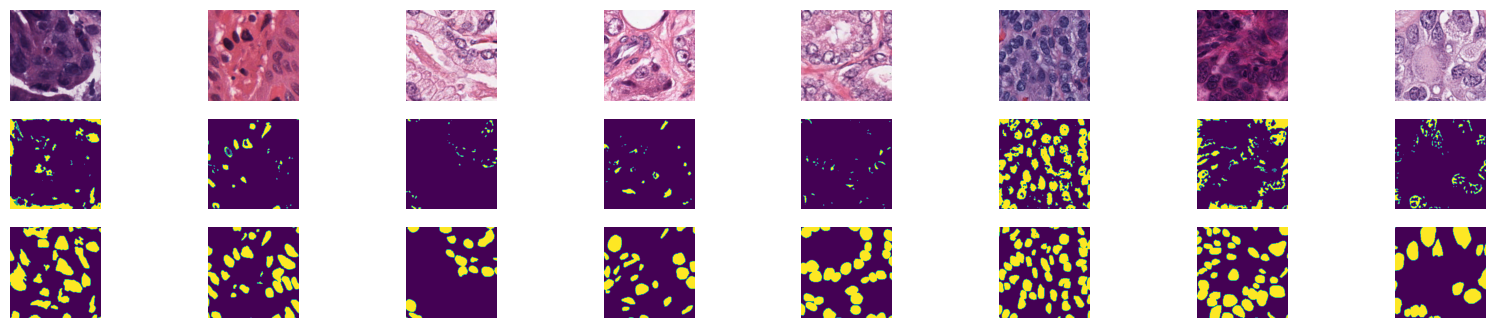

In [129]:
# @title Visualize After 20 Epoch

show_pic(model, images)

In [130]:
# @title try the same thing but with Dice Loss instead of CrossEntropy Loss

def multiclass_dice_loss(pred, target, smooth=1e-5):
    num_classes = pred.shape[1] # 2nd dim of the predicted mask, which is num_classes
    
    # convert all numbers according to the probability of the num_classes (across the C dimension of [B, C, H, W]
    pred = torch.softmax(pred, dim=1)

    # one-hot encoding the target (ground truth) to match the output
    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float() 

    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


model = UNet()

# do random split to set aside validation set
train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device=device)

train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader)
      

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 1, Training Loss: 0.5292


Epoch 1, Validation Loss: 0.4798, Accuracy: 0.7149


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 2, Training Loss: 0.5619


Epoch 2, Validation Loss: 0.5799, Accuracy: 0.7257


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 3, Training Loss: 0.5723


Epoch 3, Validation Loss: 0.5981, Accuracy: 0.6745


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

Epoch 4, Training Loss: 0.5718


Epoch 4, Validation Loss: 0.5924, Accuracy: 0.6953


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 5, Training Loss: 0.5729


Epoch 5, Validation Loss: 0.5945, Accuracy: 0.6842


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 6, Training Loss: 0.5692


Epoch 6, Validation Loss: 0.5778, Accuracy: 0.7322


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 7, Training Loss: 0.5730


Epoch 7, Validation Loss: 0.5869, Accuracy: 0.7050


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 8, Training Loss: 0.5757


Epoch 8, Validation Loss: 0.5760, Accuracy: 0.7390


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 9, Training Loss: 0.5789


Epoch 9, Validation Loss: 0.5860, Accuracy: 0.7087


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Epoch 10, Training Loss: 0.5772


Epoch 10, Validation Loss: 0.5891, Accuracy: 0.6987


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Epoch 11, Training Loss: 0.5719


Epoch 11, Validation Loss: 0.5947, Accuracy: 0.6849


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 12, Training Loss: 0.5790


Epoch 12, Validation Loss: 0.5932, Accuracy: 0.6883


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 13, Training Loss: 0.5728


Epoch 13, Validation Loss: 0.5894, Accuracy: 0.7004


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 14, Training Loss: 0.5745


Epoch 14, Validation Loss: 0.5948, Accuracy: 0.6852


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

Epoch 15, Training Loss: 0.5757


Epoch 15, Validation Loss: 0.5870, Accuracy: 0.7052


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 16, Training Loss: 0.5720


Epoch 16, Validation Loss: 0.5864, Accuracy: 0.7096


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 17, Training Loss: 0.5770


Epoch 17, Validation Loss: 0.5837, Accuracy: 0.7147


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 18, Training Loss: 0.5753


Epoch 18, Validation Loss: 0.5776, Accuracy: 0.7342


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 19, Training Loss: 0.5762


Epoch 19, Validation Loss: 0.5879, Accuracy: 0.7039


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 20, Training Loss: 0.5789


Epoch 20, Validation Loss: 0.5878, Accuracy: 0.7044


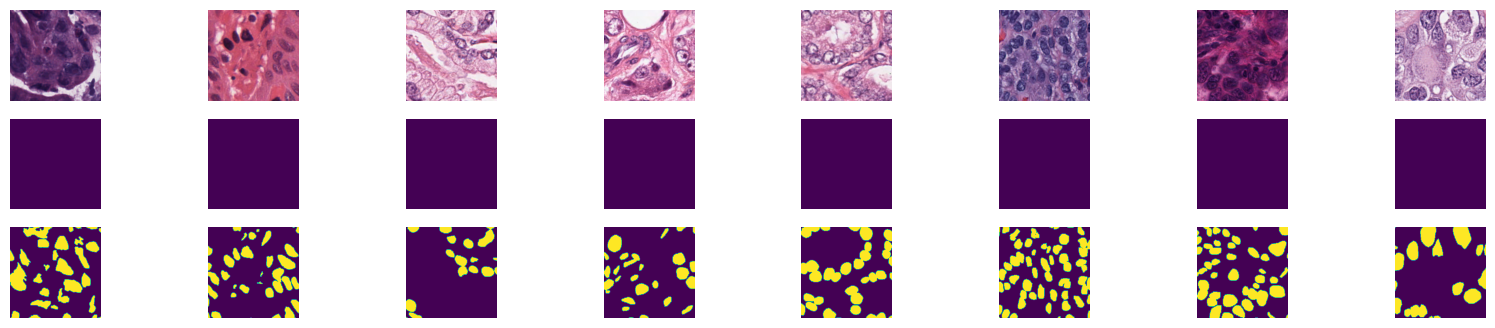

In [131]:
# Visualize after 20 Epochs: Trained using Dice Loss

show_pic(model, images)

In [135]:
# @title Hybrid Loss Function: Dice Loss + CrossEntropy

def hybrid_loss(pred, target, dice_weight=0.5):

    # CrossEntropy Loss
    ce = F.cross_entropy(pred, target)

    # Multiclass Dice Loss
    dice_loss = multiclass_dice_loss(pred, target)

    return (1 - dice_weight) * ce + dice_weight * dice_loss


model = UNet()

# do random split to set aside validation set
train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device=device)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader)

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 1, Training Loss: 0.5690


Epoch 1, Validation Loss: 1.4580, Accuracy: 0.7220


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 2, Training Loss: 0.8219


Epoch 2, Validation Loss: 0.5416, Accuracy: 0.7226


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

Epoch 3, Training Loss: 0.5407


Epoch 3, Validation Loss: 0.5467, Accuracy: 0.6832


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

Epoch 4, Training Loss: 0.5279


Epoch 4, Validation Loss: 0.5037, Accuracy: 0.7343


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 5, Training Loss: 0.4899


Epoch 5, Validation Loss: 0.4599, Accuracy: 0.7286


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Epoch 6, Training Loss: 0.4625


Epoch 6, Validation Loss: 0.4394, Accuracy: 0.7123


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 7, Training Loss: 0.4105


Epoch 7, Validation Loss: 0.4402, Accuracy: 0.6968


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 8, Training Loss: 0.3831


Epoch 8, Validation Loss: 0.4456, Accuracy: 0.7441


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 9, Training Loss: 0.4044


Epoch 9, Validation Loss: 0.4757, Accuracy: 0.6296


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 10, Training Loss: 0.4030


Epoch 10, Validation Loss: 0.4419, Accuracy: 0.6780


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

Epoch 11, Training Loss: 0.3678


Epoch 11, Validation Loss: 0.4492, Accuracy: 0.6831


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 12, Training Loss: 0.3552


Epoch 12, Validation Loss: 0.4252, Accuracy: 0.7222


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 13, Training Loss: 0.3503


Epoch 13, Validation Loss: 0.4615, Accuracy: 0.6933


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 14, Training Loss: 0.3667


Epoch 14, Validation Loss: 0.7535, Accuracy: 0.7030


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

Epoch 15, Training Loss: 0.3901


Epoch 15, Validation Loss: 0.4183, Accuracy: 0.7402


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Epoch 16, Training Loss: 0.3457


Epoch 16, Validation Loss: 0.4821, Accuracy: 0.6937


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 17, Training Loss: 0.3498


Epoch 17, Validation Loss: 0.3839, Accuracy: 0.7859


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 18, Training Loss: 0.3461


Epoch 18, Validation Loss: 0.3386, Accuracy: 0.8171


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 19, Training Loss: 0.3457


Epoch 19, Validation Loss: 0.5304, Accuracy: 0.6756


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 20, Training Loss: 0.3372


Epoch 20, Validation Loss: 0.4265, Accuracy: 0.7405


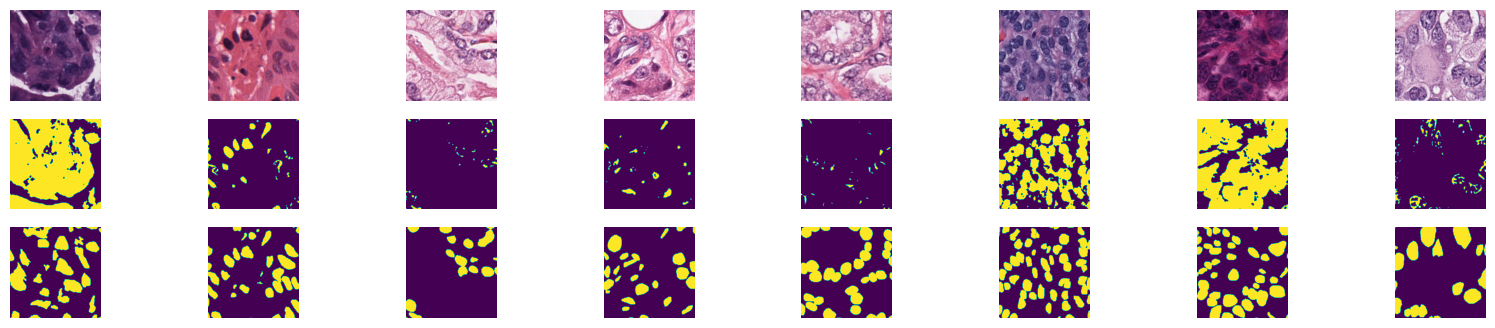

In [136]:
# Visualize after 20 Epochs: Trained using Hybrid Loss

show_pic(model, images)

In [137]:
# @title Additional Data Augmentation to Improve Overfitting Problem

# create a new dataset

transform = v2.Compose([v2.RandomCrop((256,256)), v2.RandomHorizontalFlip(), v2.RandomVerticalFlip(), v2.RandomRotation(180)])

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)


model = UNet()

# do random split to set aside validation set
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device=device)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader)

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 1, Training Loss: 0.5592


Epoch 1, Validation Loss: 0.5029, Accuracy: 0.7574


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 2, Training Loss: 0.5047


Epoch 2, Validation Loss: 0.4877, Accuracy: 0.7389


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 3, Training Loss: 0.4809


Epoch 3, Validation Loss: 0.7188, Accuracy: 0.7314


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 4, Training Loss: 0.5183


Epoch 4, Validation Loss: 0.4387, Accuracy: 0.7514


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 5, Training Loss: 0.4395


Epoch 5, Validation Loss: 0.4254, Accuracy: 0.7035


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 6, Training Loss: 0.4035


Epoch 6, Validation Loss: 0.4034, Accuracy: 0.7584


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 7, Training Loss: 0.3890


Epoch 7, Validation Loss: 0.3750, Accuracy: 0.7435


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 8, Training Loss: 0.3902


Epoch 8, Validation Loss: 0.3866, Accuracy: 0.7412


Epoch 9/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 9, Training Loss: 0.3595


Epoch 9, Validation Loss: 0.4303, Accuracy: 0.7301


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 10, Training Loss: 0.3707


Epoch 10, Validation Loss: 0.3823, Accuracy: 0.8001


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 11, Training Loss: 0.3940


Epoch 11, Validation Loss: 0.3950, Accuracy: 0.7328


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 12, Training Loss: 0.3586


Epoch 12, Validation Loss: 0.3356, Accuracy: 0.8067


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 13, Training Loss: 0.3631


Epoch 13, Validation Loss: 0.3503, Accuracy: 0.7779


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 14, Training Loss: 0.3733


Epoch 14, Validation Loss: 0.2987, Accuracy: 0.8488


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 15, Training Loss: 0.3525


Epoch 15, Validation Loss: 0.3706, Accuracy: 0.7829


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 16, Training Loss: 0.3557


Epoch 16, Validation Loss: 0.3896, Accuracy: 0.7640


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 17, Training Loss: 0.3531


Epoch 17, Validation Loss: 0.3155, Accuracy: 0.8397


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

Epoch 18, Training Loss: 0.3388


Epoch 18, Validation Loss: 0.3091, Accuracy: 0.8444


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 19, Training Loss: 0.3471


Epoch 19, Validation Loss: 0.4402, Accuracy: 0.7205


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 20, Training Loss: 0.3402


Epoch 20, Validation Loss: 0.3386, Accuracy: 0.8060


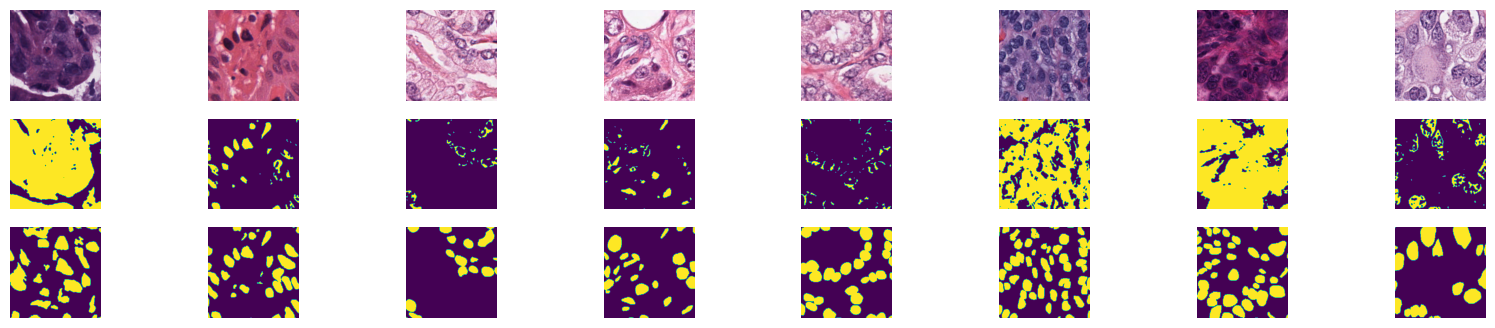

In [138]:
# @title Visualize after Data Augmentation

show_pic(model, images)

In [139]:
    # @title Implement LR Scheduling to see if I can improve training stability
    
    model = UNet()
    
    aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)
    train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15]) 
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 50 # increasing epochs
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler)

Epoch 1/50: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 1, Training Loss: 0.5704


Current Learning Rate: 0.001000
Epoch 1, Validation Loss: 0.7728, Accuracy: 0.7788


Epoch 2/50: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Epoch 2, Training Loss: 0.6046


Current Learning Rate: 0.001000
Epoch 2, Validation Loss: 0.5332, Accuracy: 0.7686


Epoch 3/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 3, Training Loss: 0.5169


Current Learning Rate: 0.001000
Epoch 3, Validation Loss: 0.5190, Accuracy: 0.7552


Epoch 4/50: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 4, Training Loss: 0.4913


Current Learning Rate: 0.001000
Epoch 4, Validation Loss: 0.5060, Accuracy: 0.7616


Epoch 5/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 5, Training Loss: 0.4883


Current Learning Rate: 0.001000
Epoch 5, Validation Loss: 0.5344, Accuracy: 0.7619


Epoch 6/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 6, Training Loss: 0.4704


Current Learning Rate: 0.001000
Epoch 6, Validation Loss: 0.4827, Accuracy: 0.7555


Epoch 7/50: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 7, Training Loss: 0.4205


Current Learning Rate: 0.001000
Epoch 7, Validation Loss: 0.4266, Accuracy: 0.7964


Epoch 8/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 8, Training Loss: 0.4106


Current Learning Rate: 0.001000
Epoch 8, Validation Loss: 0.3978, Accuracy: 0.8130


Epoch 9/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 9, Training Loss: 0.3886


Current Learning Rate: 0.001000
Epoch 9, Validation Loss: 0.3903, Accuracy: 0.8176


Epoch 10/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 10, Training Loss: 0.3837


Current Learning Rate: 0.001000
Epoch 10, Validation Loss: 0.4032, Accuracy: 0.7691


Epoch 11/50: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 11, Training Loss: 0.3734


Current Learning Rate: 0.001000
Epoch 11, Validation Loss: 0.3999, Accuracy: 0.8001


Epoch 12/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 12, Training Loss: 0.3462


Current Learning Rate: 0.001000
Epoch 12, Validation Loss: 0.3586, Accuracy: 0.8186


Epoch 13/50: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 13, Training Loss: 0.4185


Current Learning Rate: 0.001000
Epoch 13, Validation Loss: 0.6026, Accuracy: 0.8126


Epoch 14/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 14, Training Loss: 0.4432


Current Learning Rate: 0.001000
Epoch 14, Validation Loss: 0.3513, Accuracy: 0.8102


Epoch 15/50: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 15, Training Loss: 0.3823


Current Learning Rate: 0.001000
Epoch 15, Validation Loss: 0.3638, Accuracy: 0.7876


Epoch 16/50: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 16, Training Loss: 0.3696


Current Learning Rate: 0.001000
Epoch 16, Validation Loss: 0.3959, Accuracy: 0.8014


Epoch 17/50: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

Epoch 17, Training Loss: 0.3698


Current Learning Rate: 0.001000
Epoch 17, Validation Loss: 0.3704, Accuracy: 0.8580


Epoch 18/50: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 18, Training Loss: 0.3734


Current Learning Rate: 0.000500
Epoch 18, Validation Loss: 0.4029, Accuracy: 0.8025


Epoch 19/50: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 19, Training Loss: 0.3735


Current Learning Rate: 0.000500
Epoch 19, Validation Loss: 0.3977, Accuracy: 0.8126


Epoch 20/50: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 20, Training Loss: 0.3631


Current Learning Rate: 0.000500
Epoch 20, Validation Loss: 0.4150, Accuracy: 0.8206


Epoch 21/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 21, Training Loss: 0.3596


Current Learning Rate: 0.000500
Epoch 21, Validation Loss: 0.3782, Accuracy: 0.8315


Epoch 22/50: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 22, Training Loss: 0.3599


Current Learning Rate: 0.000500
Epoch 22, Validation Loss: 0.3388, Accuracy: 0.8747


Epoch 23/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 23, Training Loss: 0.3545


Current Learning Rate: 0.000500
Epoch 23, Validation Loss: 0.3385, Accuracy: 0.8682


Epoch 24/50: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

Epoch 24, Training Loss: 0.3534


Current Learning Rate: 0.000500
Epoch 24, Validation Loss: 0.3785, Accuracy: 0.8497


Epoch 25/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 25, Training Loss: 0.3504


Current Learning Rate: 0.000500
Epoch 25, Validation Loss: 0.3746, Accuracy: 0.8254


Epoch 26/50: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

Epoch 26, Training Loss: 0.3480


Current Learning Rate: 0.000500
Epoch 26, Validation Loss: 0.3082, Accuracy: 0.8622


Epoch 27/50: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

Epoch 27, Training Loss: 0.3462


Current Learning Rate: 0.000500
Epoch 27, Validation Loss: 0.3994, Accuracy: 0.8090


Epoch 28/50: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 28, Training Loss: 0.3343


Current Learning Rate: 0.000500
Epoch 28, Validation Loss: 0.3575, Accuracy: 0.8400


Epoch 29/50: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 29, Training Loss: 0.3341


Current Learning Rate: 0.000500
Epoch 29, Validation Loss: 0.3083, Accuracy: 0.8773


Epoch 30/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 30, Training Loss: 0.3273


Current Learning Rate: 0.000250
Epoch 30, Validation Loss: 0.3112, Accuracy: 0.8671


Epoch 31/50: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

Epoch 31, Training Loss: 0.3166


Current Learning Rate: 0.000250
Epoch 31, Validation Loss: 0.3408, Accuracy: 0.8453


Epoch 32/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 32, Training Loss: 0.3108


Current Learning Rate: 0.000250
Epoch 32, Validation Loss: 0.3369, Accuracy: 0.8516


Epoch 33/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 33, Training Loss: 0.3155


Current Learning Rate: 0.000250
Epoch 33, Validation Loss: 0.3837, Accuracy: 0.8242


Epoch 34/50: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

Epoch 34, Training Loss: 0.3086


Current Learning Rate: 0.000125
Epoch 34, Validation Loss: 0.3319, Accuracy: 0.8690


Epoch 35/50: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 35, Training Loss: 0.3073


Current Learning Rate: 0.000125
Epoch 35, Validation Loss: 0.3386, Accuracy: 0.8476


Epoch 36/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 36, Training Loss: 0.3044


Current Learning Rate: 0.000125
Epoch 36, Validation Loss: 0.4227, Accuracy: 0.7813


Epoch 37/50: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 37, Training Loss: 0.2953


Current Learning Rate: 0.000125
Epoch 37, Validation Loss: 0.3984, Accuracy: 0.8237


Epoch 38/50: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]

Epoch 38, Training Loss: 0.2911


Current Learning Rate: 0.000063
Epoch 38, Validation Loss: 0.3548, Accuracy: 0.8296


Epoch 39/50: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 39, Training Loss: 0.3042


Current Learning Rate: 0.000063
Epoch 39, Validation Loss: 0.3529, Accuracy: 0.8269


Epoch 40/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 40, Training Loss: 0.2930


Current Learning Rate: 0.000063
Epoch 40, Validation Loss: 0.3182, Accuracy: 0.8744


Epoch 41/50: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Epoch 41, Training Loss: 0.2942


Current Learning Rate: 0.000063
Epoch 41, Validation Loss: 0.3101, Accuracy: 0.8827


Epoch 42/50: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Epoch 42, Training Loss: 0.3130


Current Learning Rate: 0.000031
Epoch 42, Validation Loss: 0.3616, Accuracy: 0.8312


Epoch 43/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 43, Training Loss: 0.2878


Current Learning Rate: 0.000031
Epoch 43, Validation Loss: 0.3160, Accuracy: 0.8650


Epoch 44/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 44, Training Loss: 0.2901


Current Learning Rate: 0.000031
Epoch 44, Validation Loss: 0.3741, Accuracy: 0.8381


Epoch 45/50: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 45, Training Loss: 0.2904


Current Learning Rate: 0.000031
Epoch 45, Validation Loss: 0.3752, Accuracy: 0.8242


Epoch 46/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 46, Training Loss: 0.2842


Current Learning Rate: 0.000016
Epoch 46, Validation Loss: 0.3362, Accuracy: 0.8472


Epoch 47/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 47, Training Loss: 0.2932


Current Learning Rate: 0.000016
Epoch 47, Validation Loss: 0.3847, Accuracy: 0.8196


Epoch 48/50: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 48, Training Loss: 0.2926


Current Learning Rate: 0.000016
Epoch 48, Validation Loss: 0.3917, Accuracy: 0.8111


Epoch 49/50: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 49, Training Loss: 0.2909


Current Learning Rate: 0.000016
Epoch 49, Validation Loss: 0.3769, Accuracy: 0.8275


Epoch 50/50: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

Epoch 50, Training Loss: 0.2849


Current Learning Rate: 0.000008
Epoch 50, Validation Loss: 0.3384, Accuracy: 0.8496


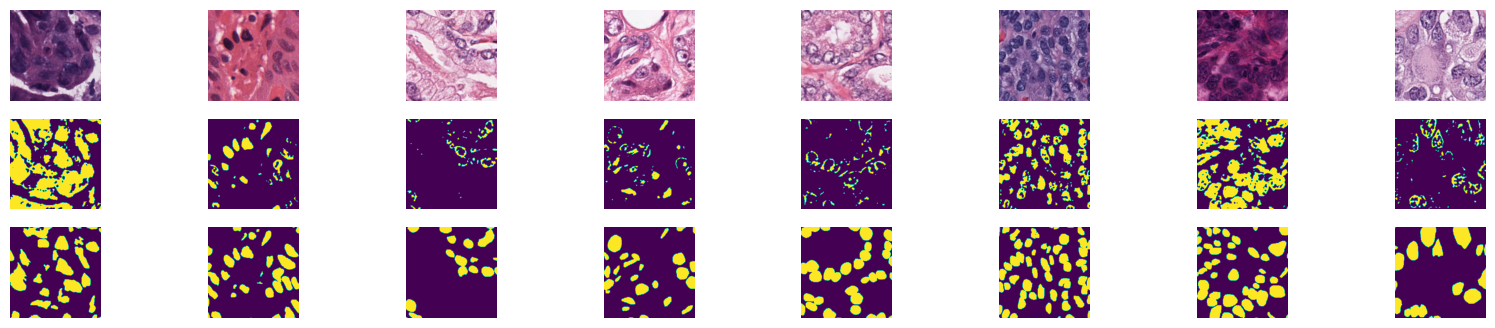

In [140]:
show_pic(model, images)

In [141]:
# @title Apply Regularization

# Weight Decay (L2 Regularization to encourage smaller weight)

model = UNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 50

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

model = model.to(device=device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler)

Epoch 1/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 1, Training Loss: 0.5656


Current Learning Rate: 0.001000
Epoch 1, Validation Loss: 0.4707, Accuracy: 0.8017


Epoch 2/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 2, Training Loss: 0.4909


Current Learning Rate: 0.001000
Epoch 2, Validation Loss: 0.4409, Accuracy: 0.8327


Epoch 3/50: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 3, Training Loss: 0.4847


Current Learning Rate: 0.001000
Epoch 3, Validation Loss: 0.4262, Accuracy: 0.8315


Epoch 4/50: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 4, Training Loss: 0.4641


Current Learning Rate: 0.001000
Epoch 4, Validation Loss: 0.3850, Accuracy: 0.8180


Epoch 5/50: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Epoch 5, Training Loss: 0.4315


Current Learning Rate: 0.001000
Epoch 5, Validation Loss: 0.3434, Accuracy: 0.8216


Epoch 6/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 6, Training Loss: 0.3969


Current Learning Rate: 0.001000
Epoch 6, Validation Loss: 0.3252, Accuracy: 0.8268


Epoch 7/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 7, Training Loss: 0.4212


Current Learning Rate: 0.001000
Epoch 7, Validation Loss: 0.3280, Accuracy: 0.8596


Epoch 8/50: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

Epoch 8, Training Loss: 0.4305


Current Learning Rate: 0.001000
Epoch 8, Validation Loss: 0.3499, Accuracy: 0.8108


Epoch 9/50: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 9, Training Loss: 0.4227


Current Learning Rate: 0.001000
Epoch 9, Validation Loss: 0.2905, Accuracy: 0.8416


Epoch 10/50: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]

Epoch 10, Training Loss: 0.4081


Current Learning Rate: 0.001000
Epoch 10, Validation Loss: 0.3429, Accuracy: 0.8693


Epoch 11/50: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 11, Training Loss: 0.3865


Current Learning Rate: 0.001000
Epoch 11, Validation Loss: 0.3290, Accuracy: 0.8418


Epoch 12/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 12, Training Loss: 0.3767


Current Learning Rate: 0.001000
Epoch 12, Validation Loss: 0.3007, Accuracy: 0.8534


Epoch 13/50: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

Epoch 13, Training Loss: 0.3660


Current Learning Rate: 0.000500
Epoch 13, Validation Loss: 0.3069, Accuracy: 0.8512


Epoch 14/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 14, Training Loss: 0.3446


Current Learning Rate: 0.000500
Epoch 14, Validation Loss: 0.3129, Accuracy: 0.8502


Epoch 15/50: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 15, Training Loss: 0.3585


Current Learning Rate: 0.000500
Epoch 15, Validation Loss: 0.2970, Accuracy: 0.8648


Epoch 16/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 16, Training Loss: 0.3498


Current Learning Rate: 0.000500
Epoch 16, Validation Loss: 0.2982, Accuracy: 0.8658


Epoch 17/50: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]

Epoch 17, Training Loss: 0.3522


Current Learning Rate: 0.000500
Epoch 17, Validation Loss: 0.2771, Accuracy: 0.8714


Epoch 18/50: 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Epoch 18, Training Loss: 0.3592


Current Learning Rate: 0.000500
Epoch 18, Validation Loss: 0.2451, Accuracy: 0.8959


Epoch 19/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 19, Training Loss: 0.3207


Current Learning Rate: 0.000500
Epoch 19, Validation Loss: 0.2489, Accuracy: 0.9025


Epoch 20/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 20, Training Loss: 0.3329


Current Learning Rate: 0.000500
Epoch 20, Validation Loss: 0.2470, Accuracy: 0.9005


Epoch 21/50: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

Epoch 21, Training Loss: 0.3398


Current Learning Rate: 0.000500
Epoch 21, Validation Loss: 0.2494, Accuracy: 0.9008


Epoch 22/50: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 22, Training Loss: 0.3368


Current Learning Rate: 0.000250
Epoch 22, Validation Loss: 0.3013, Accuracy: 0.8622


Epoch 23/50: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 23, Training Loss: 0.3281


Current Learning Rate: 0.000250
Epoch 23, Validation Loss: 0.2411, Accuracy: 0.8995


Epoch 24/50: 100%|██████████| 4/4 [00:01<00:00,  2.94it/s]

Epoch 24, Training Loss: 0.3288


Current Learning Rate: 0.000250
Epoch 24, Validation Loss: 0.3037, Accuracy: 0.8625


Epoch 25/50: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 25, Training Loss: 0.3144


Current Learning Rate: 0.000250
Epoch 25, Validation Loss: 0.2804, Accuracy: 0.8649


Epoch 26/50: 100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

Epoch 26, Training Loss: 0.3301


Current Learning Rate: 0.000250
Epoch 26, Validation Loss: 0.3014, Accuracy: 0.8552


Epoch 27/50: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 27, Training Loss: 0.3362


Current Learning Rate: 0.000125
Epoch 27, Validation Loss: 0.2588, Accuracy: 0.8873


Epoch 28/50: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

Epoch 28, Training Loss: 0.3260


Current Learning Rate: 0.000125
Epoch 28, Validation Loss: 0.2403, Accuracy: 0.9007


Epoch 29/50: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 29, Training Loss: 0.3286


Current Learning Rate: 0.000125
Epoch 29, Validation Loss: 0.2606, Accuracy: 0.8814


Epoch 30/50: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 30, Training Loss: 0.3292


Current Learning Rate: 0.000125
Epoch 30, Validation Loss: 0.2487, Accuracy: 0.9003


Epoch 31/50: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 31, Training Loss: 0.3276


Current Learning Rate: 0.000125
Epoch 31, Validation Loss: 0.2325, Accuracy: 0.9109


Epoch 32/50: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 32, Training Loss: 0.3276


Current Learning Rate: 0.000125
Epoch 32, Validation Loss: 0.2353, Accuracy: 0.9031


Epoch 33/50: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

Epoch 33, Training Loss: 0.3150


Current Learning Rate: 0.000125
Epoch 33, Validation Loss: 0.2440, Accuracy: 0.8965


Epoch 34/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 34, Training Loss: 0.3198


Current Learning Rate: 0.000125
Epoch 34, Validation Loss: 0.2566, Accuracy: 0.8846


Epoch 35/50: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 35, Training Loss: 0.3143


Current Learning Rate: 0.000063
Epoch 35, Validation Loss: 0.2635, Accuracy: 0.8802


Epoch 36/50: 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

Epoch 36, Training Loss: 0.3121


Current Learning Rate: 0.000063
Epoch 36, Validation Loss: 0.2436, Accuracy: 0.8943


Epoch 37/50: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epoch 37, Training Loss: 0.3119


Current Learning Rate: 0.000063
Epoch 37, Validation Loss: 0.2454, Accuracy: 0.8927


Epoch 38/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 38, Training Loss: 0.3109


Current Learning Rate: 0.000063
Epoch 38, Validation Loss: 0.2533, Accuracy: 0.8802


Epoch 39/50: 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

Epoch 39, Training Loss: 0.2996


Current Learning Rate: 0.000031
Epoch 39, Validation Loss: 0.2402, Accuracy: 0.8978


Epoch 40/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 40, Training Loss: 0.3129


Current Learning Rate: 0.000031
Epoch 40, Validation Loss: 0.2583, Accuracy: 0.8740


Epoch 41/50: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

Epoch 41, Training Loss: 0.3026


Current Learning Rate: 0.000031
Epoch 41, Validation Loss: 0.2444, Accuracy: 0.8909


Epoch 42/50: 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

Epoch 42, Training Loss: 0.3077


Current Learning Rate: 0.000031
Epoch 42, Validation Loss: 0.2505, Accuracy: 0.8858


Epoch 43/50: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 43, Training Loss: 0.3208


Current Learning Rate: 0.000016
Epoch 43, Validation Loss: 0.2513, Accuracy: 0.8863


Epoch 44/50: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

Epoch 44, Training Loss: 0.3244


Current Learning Rate: 0.000016
Epoch 44, Validation Loss: 0.2407, Accuracy: 0.8901


Epoch 45/50: 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

Epoch 45, Training Loss: 0.3089


Current Learning Rate: 0.000016
Epoch 45, Validation Loss: 0.2341, Accuracy: 0.9016


Epoch 46/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 46, Training Loss: 0.3194


Current Learning Rate: 0.000016
Epoch 46, Validation Loss: 0.2327, Accuracy: 0.9016


Epoch 47/50: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

Epoch 47, Training Loss: 0.3152


Current Learning Rate: 0.000008
Epoch 47, Validation Loss: 0.2551, Accuracy: 0.8835


Epoch 48/50: 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

Epoch 48, Training Loss: 0.3086


Current Learning Rate: 0.000008
Epoch 48, Validation Loss: 0.2374, Accuracy: 0.8954


Epoch 49/50: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

Epoch 49, Training Loss: 0.3076


Current Learning Rate: 0.000008
Epoch 49, Validation Loss: 0.2550, Accuracy: 0.8798


Epoch 50/50: 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

Epoch 50, Training Loss: 0.3138


Current Learning Rate: 0.000008
Epoch 50, Validation Loss: 0.2661, Accuracy: 0.8774


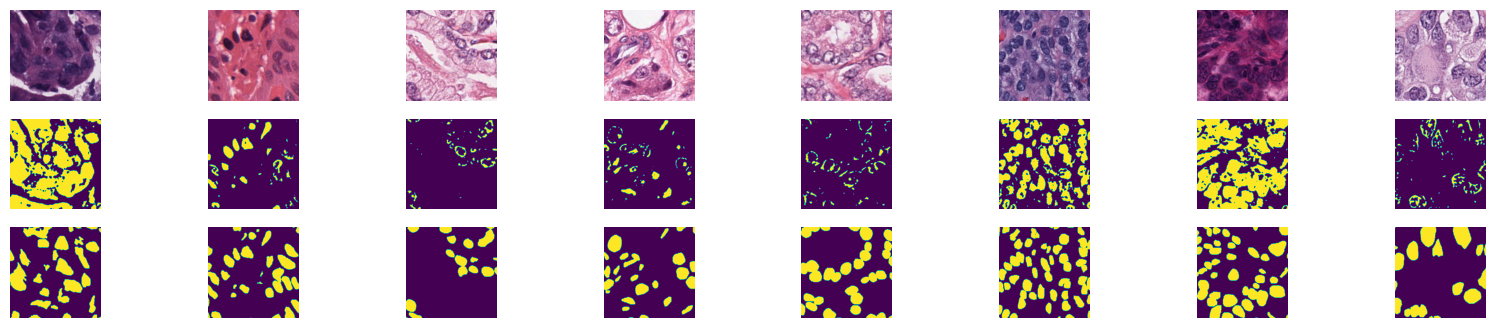

In [142]:
# @title Visualize after Regularization

show_pic(model, images)

In [143]:
# @title Increase Batchsize

model = UNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 50

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2) # Doesn't matter here since I'm not updating gradient

model = model.to(device=device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler)

Epoch 1/50: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

Epoch 1, Training Loss: 0.6208


Current Learning Rate: 0.001000
Epoch 1, Validation Loss: 0.5932, Accuracy: 0.7281


Epoch 2/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 2, Training Loss: 0.5881


Current Learning Rate: 0.001000
Epoch 2, Validation Loss: 0.5190, Accuracy: 0.7569


Epoch 3/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 3, Training Loss: 0.6360


Current Learning Rate: 0.001000
Epoch 3, Validation Loss: 0.5242, Accuracy: 0.7254


Epoch 4/50: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

Epoch 4, Training Loss: 0.4905


Current Learning Rate: 0.001000
Epoch 4, Validation Loss: 0.5105, Accuracy: 0.7636


Epoch 5/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 5, Training Loss: 0.5127


Current Learning Rate: 0.001000
Epoch 5, Validation Loss: 0.5182, Accuracy: 0.7511


Epoch 6/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 6, Training Loss: 0.5100


Current Learning Rate: 0.001000
Epoch 6, Validation Loss: 0.4948, Accuracy: 0.7710


Epoch 7/50: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

Epoch 7, Training Loss: 0.4891


Current Learning Rate: 0.001000
Epoch 7, Validation Loss: 0.4676, Accuracy: 0.7813


Epoch 8/50: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

Epoch 8, Training Loss: 0.4683


Current Learning Rate: 0.001000
Epoch 8, Validation Loss: 0.4884, Accuracy: 0.7443


Epoch 9/50: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

Epoch 9, Training Loss: 0.4811


Current Learning Rate: 0.001000
Epoch 9, Validation Loss: 0.4877, Accuracy: 0.7347


Epoch 10/50: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

Epoch 10, Training Loss: 0.4662


Current Learning Rate: 0.001000
Epoch 10, Validation Loss: 0.4755, Accuracy: 0.7249


Epoch 11/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 11, Training Loss: 0.4353


Current Learning Rate: 0.001000
Epoch 11, Validation Loss: 0.4365, Accuracy: 0.7435


Epoch 12/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 12, Training Loss: 0.4315


Current Learning Rate: 0.001000
Epoch 12, Validation Loss: 0.4353, Accuracy: 0.7501


Epoch 13/50: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

Epoch 13, Training Loss: 0.4226


Current Learning Rate: 0.001000
Epoch 13, Validation Loss: 0.4022, Accuracy: 0.7624


Epoch 14/50: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

Epoch 14, Training Loss: 0.3980


Current Learning Rate: 0.001000
Epoch 14, Validation Loss: 0.3962, Accuracy: 0.7567


Epoch 15/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 15, Training Loss: 0.3803


Current Learning Rate: 0.001000
Epoch 15, Validation Loss: 0.3633, Accuracy: 0.7944


Epoch 16/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 16, Training Loss: 0.3729


Current Learning Rate: 0.001000
Epoch 16, Validation Loss: 0.3799, Accuracy: 0.7728


Epoch 17/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 17, Training Loss: 0.3665


Current Learning Rate: 0.001000
Epoch 17, Validation Loss: 0.3756, Accuracy: 0.8274


Epoch 18/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 18, Training Loss: 0.3661


Current Learning Rate: 0.001000
Epoch 18, Validation Loss: 0.4137, Accuracy: 0.8136


Epoch 19/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 19, Training Loss: 0.3557


Current Learning Rate: 0.000500
Epoch 19, Validation Loss: 0.3758, Accuracy: 0.8273


Epoch 20/50: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

Epoch 20, Training Loss: 0.3661


Current Learning Rate: 0.000500
Epoch 20, Validation Loss: 0.3910, Accuracy: 0.8126


Epoch 21/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 21, Training Loss: 0.3613


Current Learning Rate: 0.000500
Epoch 21, Validation Loss: 0.3682, Accuracy: 0.8415


Epoch 22/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 22, Training Loss: 0.3606


Current Learning Rate: 0.000500
Epoch 22, Validation Loss: 0.3877, Accuracy: 0.8270


Epoch 23/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 23, Training Loss: 0.3478


Current Learning Rate: 0.000250
Epoch 23, Validation Loss: 0.4147, Accuracy: 0.7758


Epoch 24/50: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

Epoch 24, Training Loss: 0.3460


Current Learning Rate: 0.000250
Epoch 24, Validation Loss: 0.3564, Accuracy: 0.8130


Epoch 25/50: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

Epoch 25, Training Loss: 0.3443


Current Learning Rate: 0.000250
Epoch 25, Validation Loss: 0.6212, Accuracy: 0.6028


Epoch 26/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 26, Training Loss: 0.4540


Current Learning Rate: 0.000250
Epoch 26, Validation Loss: 0.3416, Accuracy: 0.8588


Epoch 27/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 27, Training Loss: 0.3690


Current Learning Rate: 0.000250
Epoch 27, Validation Loss: 0.3871, Accuracy: 0.8468


Epoch 28/50: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

Epoch 28, Training Loss: 0.3993


Current Learning Rate: 0.000250
Epoch 28, Validation Loss: 0.4584, Accuracy: 0.8229


Epoch 29/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 29, Training Loss: 0.3673


Current Learning Rate: 0.000250
Epoch 29, Validation Loss: 0.4143, Accuracy: 0.8053


Epoch 30/50: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

Epoch 30, Training Loss: 0.3505


Current Learning Rate: 0.000125
Epoch 30, Validation Loss: 0.3803, Accuracy: 0.7923


Epoch 31/50: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

Epoch 31, Training Loss: 0.3606


Current Learning Rate: 0.000125
Epoch 31, Validation Loss: 0.3960, Accuracy: 0.7849


Epoch 32/50: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

Epoch 32, Training Loss: 0.3619


Current Learning Rate: 0.000125
Epoch 32, Validation Loss: 0.4106, Accuracy: 0.7689


Epoch 33/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 33, Training Loss: 0.3526


Current Learning Rate: 0.000125
Epoch 33, Validation Loss: 0.4187, Accuracy: 0.7768


Epoch 34/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 34, Training Loss: 0.3577


Current Learning Rate: 0.000063
Epoch 34, Validation Loss: 0.3679, Accuracy: 0.8207


Epoch 35/50: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

Epoch 35, Training Loss: 0.3678


Current Learning Rate: 0.000063
Epoch 35, Validation Loss: 0.3789, Accuracy: 0.8159


Epoch 36/50: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

Epoch 36, Training Loss: 0.3466


Current Learning Rate: 0.000063
Epoch 36, Validation Loss: 0.3601, Accuracy: 0.8381


Epoch 37/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 37, Training Loss: 0.3717


Current Learning Rate: 0.000063
Epoch 37, Validation Loss: 0.3446, Accuracy: 0.8407


Epoch 38/50: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

Epoch 38, Training Loss: 0.3629


Current Learning Rate: 0.000031
Epoch 38, Validation Loss: 0.3790, Accuracy: 0.8213


Epoch 39/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 39, Training Loss: 0.3602


Current Learning Rate: 0.000031
Epoch 39, Validation Loss: 0.3686, Accuracy: 0.8235


Epoch 40/50: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

Epoch 40, Training Loss: 0.3626


Current Learning Rate: 0.000031
Epoch 40, Validation Loss: 0.3662, Accuracy: 0.8283


Epoch 41/50: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

Epoch 41, Training Loss: 0.3642


Current Learning Rate: 0.000031
Epoch 41, Validation Loss: 0.3955, Accuracy: 0.8119


Epoch 42/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 42, Training Loss: 0.3623


Current Learning Rate: 0.000016
Epoch 42, Validation Loss: 0.3428, Accuracy: 0.8247


Epoch 43/50: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

Epoch 43, Training Loss: 0.3507


Current Learning Rate: 0.000016
Epoch 43, Validation Loss: 0.4264, Accuracy: 0.7965


Epoch 44/50: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

Epoch 44, Training Loss: 0.3442


Current Learning Rate: 0.000016
Epoch 44, Validation Loss: 0.3963, Accuracy: 0.8022


Epoch 45/50: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

Epoch 45, Training Loss: 0.3499


Current Learning Rate: 0.000016
Epoch 45, Validation Loss: 0.3734, Accuracy: 0.8352


Epoch 46/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 46, Training Loss: 0.3678


Current Learning Rate: 0.000008
Epoch 46, Validation Loss: 0.3785, Accuracy: 0.8200


Epoch 47/50: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

Epoch 47, Training Loss: 0.3403


Current Learning Rate: 0.000008
Epoch 47, Validation Loss: 0.4005, Accuracy: 0.8083


Epoch 48/50: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

Epoch 48, Training Loss: 0.3585


Current Learning Rate: 0.000008
Epoch 48, Validation Loss: 0.3960, Accuracy: 0.8040


Epoch 49/50: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

Epoch 49, Training Loss: 0.3651


Current Learning Rate: 0.000008
Epoch 49, Validation Loss: 0.4005, Accuracy: 0.7990


Epoch 50/50: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

Epoch 50, Training Loss: 0.3746


Current Learning Rate: 0.000004
Epoch 50, Validation Loss: 0.3693, Accuracy: 0.8344


In [147]:
# @title Reduce Batchsize back down to 8, Add Data Augmentation: Brightness/Contrast

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform=transform, bright_contrast=True)
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

model = UNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 50

model = model.to(device=device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler)

Epoch 1/50:   0%|          | 0/4 [00:00<?, ?it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 399, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 399, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_267/3656056250.py", line 44, in __getitem__
    img = self.img_transform(img)
          ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_container.py", line 51, in forward
    outputs = transform(*inputs)
              ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_transform.py", line 46, in forward
    params = self._get_params(
             ^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_color.py", line 211, in _get_params
    params: Dict[str, Any] = {
                             ^
  File "/opt/conda/lib/python3.11/site-packages/torchvision/transforms/v2/_color.py", line 212, in <dictcomp>
    key: ColorJitter._generate_value(range[0], range[1]) if torch.rand(1) < self.p else None
                                     ~~~~~^^^
TypeError: 'float' object is not subscriptable
